<a href="https://colab.research.google.com/github/solvedbrunus/Project-3---IronHack/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Review Analysis and Product Categorization
## Using NLP and LLMs

In [ ]:
!pip install bertopic

!pip install datasets

!pip install -U bitsandbytes

!pip install -U transformers

In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from transformers import pipeline
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


# Download required NLTK data
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# Importing transformers and torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Importing BERTopic and HDBSCAN
from bertopic import BERTopic
from hdbscan import HDBSCAN

# Importing sklearn modules
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.metrics import silhouette_score, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

# Importing datasets
from datasets import Dataset

# Importing transformers for sequence classification
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Load Data

In [ ]:
## 1. Load the data from the CSV file
# Load your dataset
df = pd.read_csv('/content/1429_1.csv')  # Replace with your file path

<ipython-input-3-71e28eda39f6>:3: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/1429_1.csv')  # Replace with your file path


In [ ]:
# Display basic information
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nMissing Values:\n", df.isnull().sum())
print("\nSample Data:\n", df.head())

Dataset Shape: (34660, 21)

Columns: ['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer', 'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title', 'reviews.userCity', 'reviews.userProvince', 'reviews.username']

Missing Values:
 id                          0
name                     6760
asins                       2
brand                       0
categories                  0
keys                        0
manufacturer                0
reviews.date               39
reviews.dateAdded       10621
reviews.dateSeen            0
reviews.didPurchase     34659
reviews.doRecommend       594
reviews.id              34659
reviews.numHelpful        529
reviews.rating             33
reviews.sourceURLs          0
reviews.text                1
reviews.title               6
reviews.userCity        34660
reviews.userProvince    3466

# 2. Data Cleaning

In [ ]:
def clean_text(text):
    # Convert to string if not already
    text = str(text)
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

# Drop duplicates
df = df.drop_duplicates()

# Drop rows with missing values in 'reviews.text' and 'reviews.rating'
df = df.dropna(subset=['reviews.text', 'reviews.rating'])

# Apply text cleaning
df['cleaned_text'] = df['reviews.text'].apply(clean_text)


In [ ]:
# 3. Create Sentiment Labels (based on ratings if available)
def assign_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

if 'reviews.rating' in df.columns:
    df['sentiment'] = df['reviews.rating'].apply(assign_sentiment)

# Check if the sentiment labels are assigned correctly
print(df['sentiment'].value_counts())

sentiment
positive    32315
neutral      1499
negative      812
Name: count, dtype: int64


## 1. Data Preprocessing

In [ ]:
def preprocess_text(text):
    # Initialize tools
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Clean and tokenize
    text = text.lower()
    tokens = word_tokenize(text)

    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens
             if token not in stop_words and token.isalnum()]

    return ' '.join(tokens)


In [ ]:
# Apply preprocessing to 'cleaned_text'
df['cleaned_text'] = df['cleaned_text'].apply(preprocess_text)

# Display the cleaned text
print(df['cleaned_text'].head())


0    product far disappointed child love use like a...
1    great beginner experienced person bought gift ...
2    inexpensive tablet use learn step nabi thrille...
3    ive fire hd two week love tablet great valuewe...
4    bought grand daughter come visit set user ente...
Name: cleaned_text, dtype: object


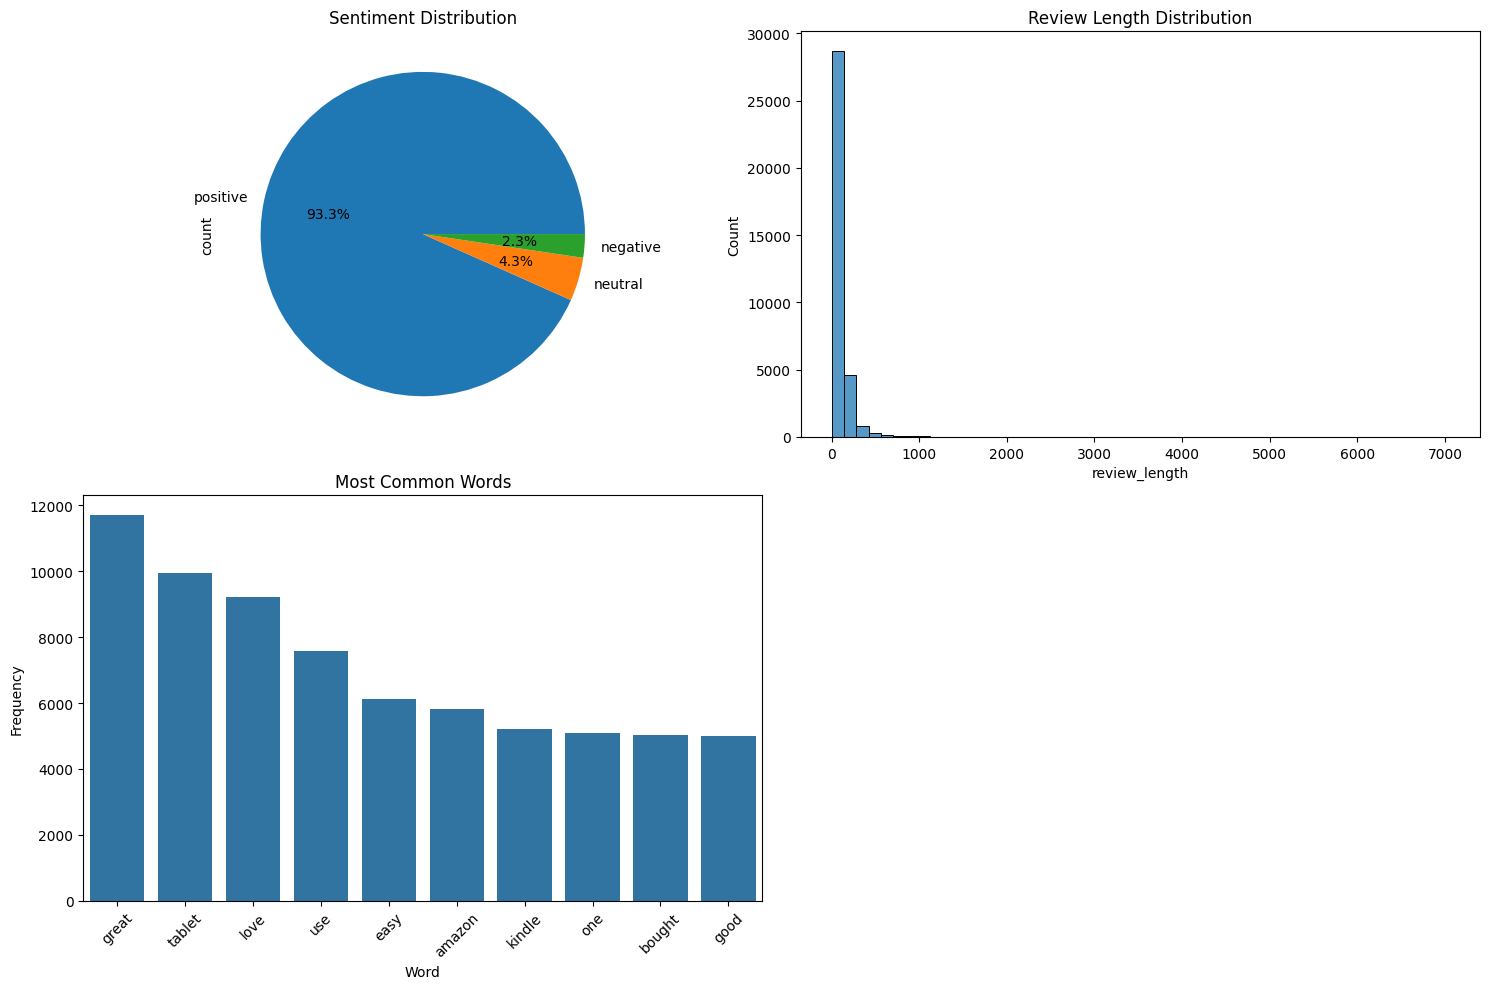


Dataset Summary:
Total reviews: 34626

Sentiment Distribution:
sentiment
positive    93.3
neutral      4.3
negative     2.3
Name: proportion, dtype: float64

Average review length: 96


In [ ]:
# 5. Visualizations
plt.figure(figsize=(15, 10))

# Sentiment Distribution Pie Chart
plt.subplot(2, 2, 1)
df['sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Sentiment Distribution')

# Review Length Distribution
plt.subplot(2, 2, 2)
df['review_length'] = df['cleaned_text'].str.len()
sns.histplot(data=df, x='review_length', bins=50)
plt.title('Review Length Distribution')

# Most Common Words
from collections import Counter
words = ' '.join(df['cleaned_text']).split()
word_freq = Counter(words).most_common(10)
words_df = pd.DataFrame(word_freq, columns=['Word', 'Frequency'])

plt.subplot(2, 2, 3)
sns.barplot(data=words_df, x='Word', y='Frequency')
plt.xticks(rotation=45)
plt.title('Most Common Words')

# Rating Distribution (if available)
if 'rating' in df.columns:
    plt.subplot(2, 2, 4)
    sns.countplot(data=df, x='rating')
    plt.title('Rating Distribution')

plt.tight_layout()
plt.show()

# 6. Save cleaned dataset
df.to_csv('cleaned_reviews.csv', index=False)

# Print summary statistics
print("\nDataset Summary:")
print(f"Total reviews: {len(df)}")
print("\nSentiment Distribution:")
print(df['sentiment'].value_counts(normalize=True).round(3) * 100)
print("\nAverage review length:", int(df['review_length'].mean()))

In [ ]:
clean_text = pd.read_csv('cleaned_reviews.csv')

<ipython-input-10-e4fae4acfa1a>:1: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  clean_text = pd.read_csv('cleaned_reviews.csv')


In [ ]:
clean_text[['cleaned_text', 'sentiment']].head()

,cleaned_text,sentiment
0,product far disappointed child love use like a...,positive
1,great beginner experienced person bought gift ...,positive
2,inexpensive tablet use learn step nabi thrille...,positive
3,ive fire hd two week love tablet great valuewe...,positive
4,bought grand daughter come visit set user ente...,positive


In [ ]:
#balance the dataset 800 reviews each label
#split the data set in to train and test
#apply the pre trained model sentiment-roberta-large-english-3-classes

# Balance the dataset
positive = clean_text[clean_text['sentiment'] == 'positive'].sample(800, random_state=42)
neutral = clean_text[clean_text['sentiment'] == 'neutral'].sample(800, random_state=42)
negative = clean_text[clean_text['sentiment'] == 'negative'].sample(800, random_state=42)

balanced_df = pd.concat([positive, neutral, negative])

## 2. Sentiment Classification using Pre-trained Model

In [ ]:
# Split the dataset into train and test sets

X = balanced_df['cleaned_text']
y = balanced_df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:

# Load the pre-trained sentiment analysis model roBERTa large english 3 classes
classifier = pipeline("text-classification", model="j-hartmann/sentiment-roberta-large-english-3-classes", device=0, return_all_scores=True)

# Predict sentiment on the test set
predictions = classifier(X_test.tolist())

# Extract the predicted labels
predicted_labels = [max(pred, key=lambda x: x['score'])['label'] for pred in predictions]

# Evaluate the model
from sklearn.metrics import classification_report

print(classification_report(y_test, predicted_labels))

# Save the balanced dataset
balanced_df.to_csv('balanced_reviews.csv', index=False)



Some weights of the model checkpoint at j-hartmann/sentiment-roberta-large-english-3-classes were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


              precision    recall  f1-score   support

    negative       0.59      0.51      0.55       157
     neutral       0.38      0.44      0.41       155
    positive       0.68      0.68      0.68       168

    accuracy                           0.55       480
   macro avg       0.55      0.54      0.55       480
weighted avg       0.56      0.55      0.55       480



In [ ]:
#save the model
classifier.save_pretrained("sentiment_model")

# Load the saved model
classifier = pipeline("text-classification", model="sentiment_model", device=0, return_all_scores=True)

Device set to use cuda:0


In [ ]:
# fine tune the model with the balanced dataset with more epochs

# Load the balanced dataset
balanced_df = pd.read_csv('balanced_reviews.csv')

# Ensure the cleaned_text column contains only strings and handle missing values
balanced_df['cleaned_text'] = balanced_df['cleaned_text'].astype(str).fillna('')

X = balanced_df['cleaned_text']
y = balanced_df['sentiment']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Create a Dataset object
dataset = Dataset.from_pandas(pd.DataFrame({'text': X, 'label': y_encoded}))

# Split the dataset into train and test sets
train_test_split = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("j-hartmann/sentiment-roberta-large-english-3-classes")
model = AutoModelForSequenceClassification.from_pretrained("j-hartmann/sentiment-roberta-large-english-3-classes")

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Ensure the datasets have the correct format for training
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Fine-tune the model
trainer.train()

# Predict sentiment on the test set
predictions = trainer.predict(test_dataset)
predicted_labels = label_encoder.inverse_transform(predictions.predictions.argmax(axis=1))

# Evaluate the fine-tuned model
true_labels = test_dataset['label'].numpy()  # Ensure true labels are in numpy array format


Some weights of the model checkpoint at j-hartmann/sentiment-roberta-large-english-3-classes were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/1920 [00:00<?, ? examples/s]

Map:   0%|          | 0/480 [00:00<?, ? examples/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: solved-pt (solved-pt-ironhack). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,No log,0.916696
2,No log,0.837662
3,0.860600,1.023507
4,0.860600,1.224155
5,0.558100,1.431013
6,0.558100,1.595922
7,0.391700,1.848765
8,0.391700,2.147141
9,0.263800,2.283014
10,0.263800,2.240419


In [ ]:
print(classification_report(label_encoder.inverse_transform(true_labels), predicted_labels))

              precision    recall  f1-score   support

    negative       0.74      0.65      0.69       163
     neutral       0.56      0.62      0.59       169
    positive       0.69      0.68      0.68       148

    accuracy                           0.65       480
   macro avg       0.66      0.65      0.65       480
weighted avg       0.66      0.65      0.65       480



## 3. Category Clustering - group similar reviews - type of product

In [ ]:
# Load the balanced dataset
balanced_df = pd.read_csv('balanced_reviews.csv')

# Ensure the cleaned_text column contains only strings and handle missing values
balanced_df['cleaned_text'] = balanced_df['cleaned_text'].astype(str).fillna('')
X = balanced_df['cleaned_text']

In [ ]:
# Create a BERTopic model
topic_model = BERTopic(language="english")

# Fit the model on the review data
topics, probabilities = topic_model.fit_transform(X)

# Extract topics and their representative terms
topic_info = topic_model.get_topic_info()
representative_terms = {topic: topic_model.get_topic(topic) for topic in topic_info.Topic.unique()}

# Display the topics and their representative terms
print(topic_info)
for topic, terms in representative_terms.items():
    print(f"Topic {topic}: {terms}")

   Topic  Count                         Name  \
0      0   2057   0_tablet_amazon_great_good   
1      1    343  1_alexa_echo_music_question   

                                      Representation  \
0  [tablet, amazon, great, good, kindle, use, one...   
1  [alexa, echo, music, question, answer, home, s...   

                                 Representative_Docs  
0  [hii ordered daughter extensive liking tablet ...  
1  [interested echo respective echo dot based pot...  
Topic 0: [('tablet', 0.0751882685880353), ('amazon', 0.05144428836189142), ('great', 0.043776128351223215), ('good', 0.04240743885336478), ('kindle', 0.04047130466611183), ('use', 0.03987729092389296), ('one', 0.038015446908449955), ('bought', 0.03771323612613319), ('work', 0.036744690907615715), ('fire', 0.03602252269172518)]
Topic 1: [('alexa', 0.11172015033874158), ('echo', 0.09574813049045673), ('music', 0.09182583082344666), ('question', 0.06954179136478734), ('answer', 0.052307271226538145), ('home', 0.0516144

In [ ]:
# Function to calculate coherence score
def calculate_coherence_score(model, texts):
    from gensim.models.coherencemodel import CoherenceModel
    from gensim.corpora.dictionary import Dictionary
    topics = model.get_topics()
    # Convert topics to the required format
    formatted_topics = [[word for word, _ in topic] for topic in topics.values()]
    # Create a Gensim dictionary from the texts
    dictionary = Dictionary([text.split() for text in texts])
    coherence_model = CoherenceModel(topics=formatted_topics, texts=[text.split() for text in texts], dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()


# Function to calculate silhouette score
def calculate_silhouette_score(model, embeddings):
    # Get the topics directly from the model's fit_transform result
    labels = model.topics_
    # Reshape embeddings to be 2D
    if embeddings.ndim == 1:
        embeddings = embeddings.reshape(-1, 1)
    return silhouette_score(embeddings, labels)

# Function to calculate elbow method score
def calculate_elbow_method(model, docs, embeddings, max_clusters=10):
    distortions = []
    for k in range(1, max_clusters + 1):
        # Reduce topics with original documents
        reduced_model = model.reduce_topics(docs, nr_topics=k)
        # Calculate distortion using the reduced model
        topics, _ = reduced_model.transform(docs)
        distortions.append(np.sum(np.square(topics)))
    return distortions



# Calculate coherence score
coherence_score = calculate_coherence_score(topic_model, X)
print(f"Coherence Score: {coherence_score}")

# Calculate silhouette score
silhouette_score_value = calculate_silhouette_score(topic_model, probabilities)
print(f"Silhouette Score: {silhouette_score_value}")


Coherence Score: 0.5800252130672383
Silhouette Score: 0.5878442160776194


## hyperparameter optimization

In [ ]:

# Define the parameter grid for hyperparameter optimization
param_grid = {
    'n_neighbors': [5, 10, 15],
    'min_topic_size': [10, 20, 30],
    'embedding_model': ['paraphrase-MiniLM-L6-v2', 'all-MiniLM-L6-v2']
}

# Initialize variables to store the best model and scores
best_model = None
best_coherence_score = -1
best_params = None

# Perform grid search
for params in ParameterGrid(param_grid):
    # Create a BERTopic model with the current parameters
    hdbscan_model = HDBSCAN(min_cluster_size=params['min_topic_size'], min_samples=params['n_neighbors'])
    model = BERTopic(
        language="english",
        hdbscan_model=hdbscan_model,
        embedding_model=params['embedding_model']
    )

    # Fit the model on the review data
    topics, probabilities = model.fit_transform(X)

    # Calculate coherence score
    coherence_score = calculate_coherence_score(model, X)

    # Update the best model if the current model has a higher coherence score
    if coherence_score > best_coherence_score:
        best_coherence_score = coherence_score
        best_model = model
        best_params = params

# Display the best parameters and coherence score
print(f"Best Parameters: {best_params}")
print(f"Best Coherence Score: {best_coherence_score}")

# Fit the best model on the review data
topics, probabilities = best_model.fit_transform(X)

# Extract topics and their representative terms
topic_info = best_model.get_topic_info()
representative_terms = {topic: best_model.get_topic(topic) for topic in topic_info.Topic.unique()}

# Display the topics and their representative terms
print(topic_info)
for topic, terms in representative_terms.items():
    print(f"Topic {topic}: {terms}")

# Calculate silhouette score for the best model
silhouette_score_value = calculate_silhouette_score(best_model, probabilities)
print(f"Silhouette Score: {silhouette_score_value}")

Best Parameters: {'embedding_model': 'paraphrase-MiniLM-L6-v2', 'min_topic_size': 30, 'n_neighbors': 15}
Best Coherence Score: 0.5967265027666812
    Topic  Count                              Name  \
0      -1    680      -1_tablet_slow_screen_bought   
1       0    314           0_tablet_kid_good_price   
2       1    297       1_alexa_echo_music_question   
3       2    276             2_tv_amazon_fire_wifi   
4       3    179          3_product_buy_great_good   
5       4    178        4_kindle_book_read_reading   
6       5    104            5_gift_love_bought_old   
7       6     85      6_battery_life_tablet_charge   
8       7     71  7_charger_charge_kindle_charging   
9       8     70          8_apps_google_store_play   
10      9     67          9_tablet_amazon_apps_app   
11     10     44         10_ipad_book_reading_read   
12     11     35            11_kid_game_child_play   

                                       Representation  \
0   [tablet, slow, screen, bought, get, 

# Analyze Topic Distribution
Examine the distribution of documents across topics and identify dominant themes in product reviews.

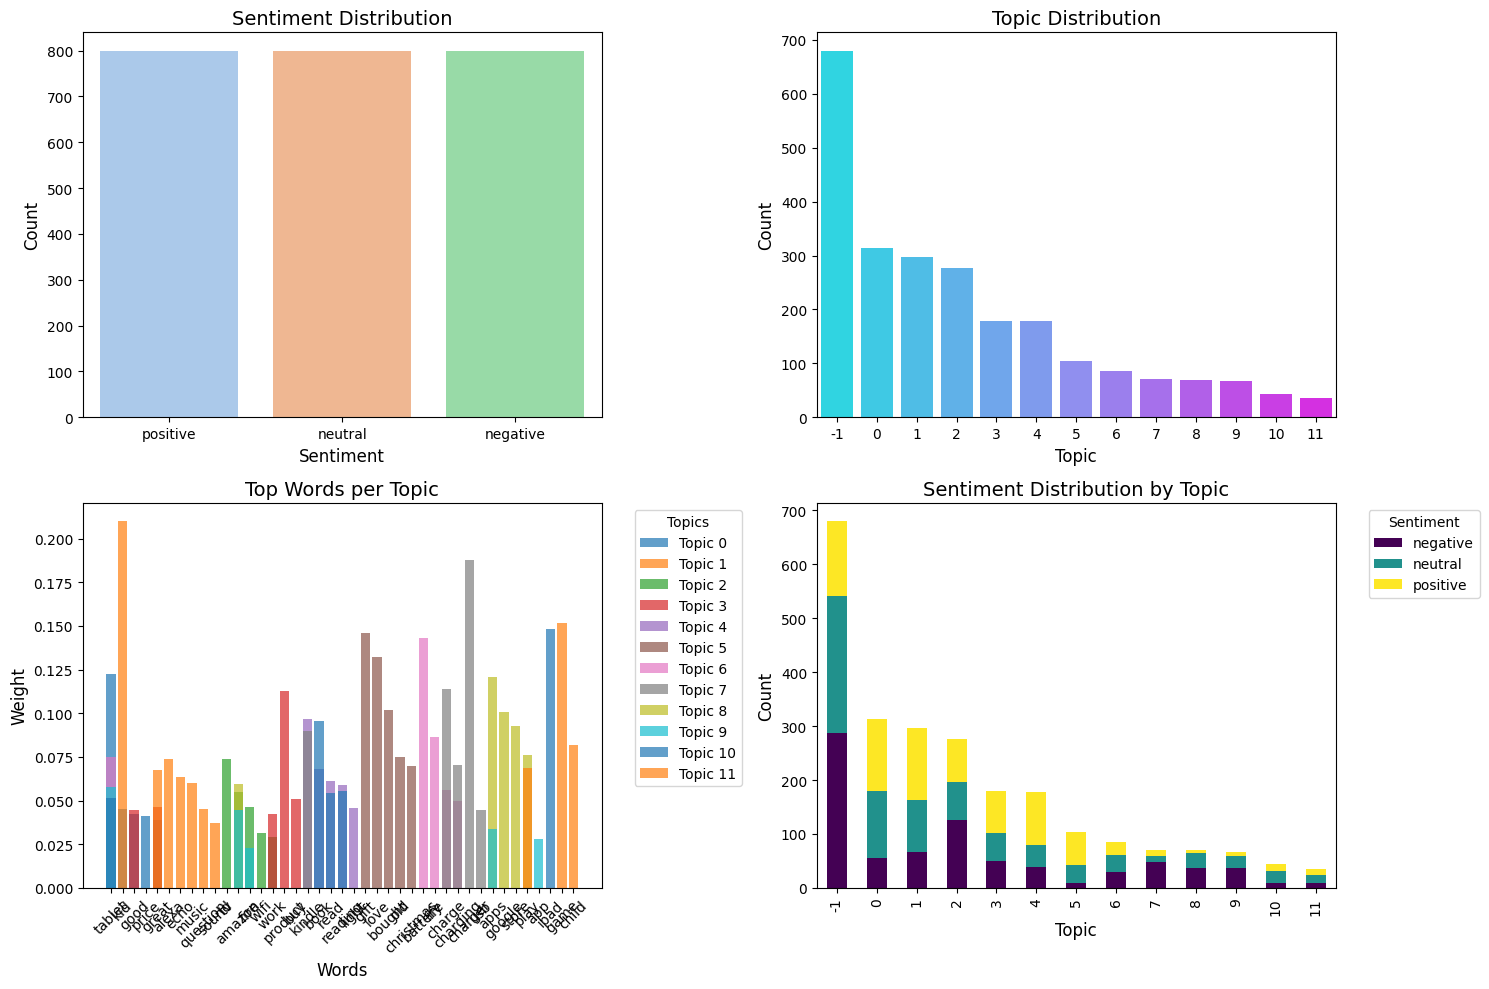

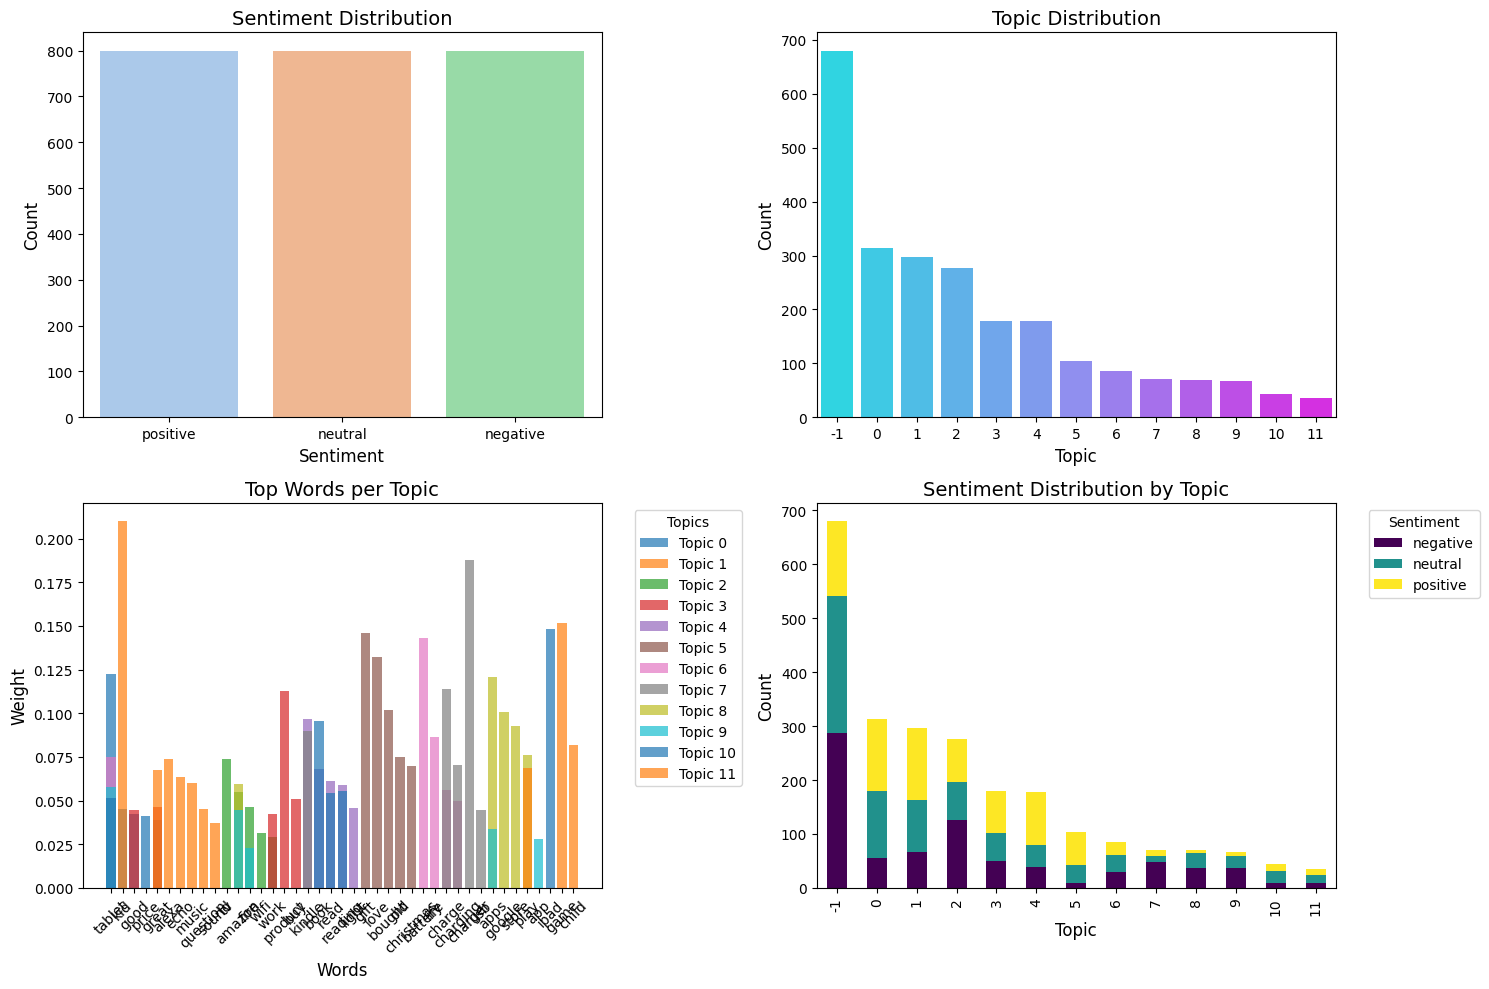

In [ ]:
# Create a figure with multiple subplots
plt.figure(figsize=(15, 10))

# 1. Sentiment Distribution Plot
plt.subplot(2, 2, 1)
sentiment_counts = balanced_df['sentiment'].value_counts()
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="pastel")
plt.title('Sentiment Distribution', fontsize=14)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)

# 2. Topic Distribution Plot
plt.subplot(2, 2, 2)
topic_counts = pd.Series(topics).value_counts()
sns.barplot(x=topic_counts.index, y=topic_counts.values, palette="cool")
plt.title('Topic Distribution', fontsize=14)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Topic', fontsize=12)

# 3. Topic Keywords Visualization
plt.subplot(2, 2, 3)
for topic_id in representative_terms.keys():
    if topic_id != -1:  # Skip the outlier topic (-1) if not needed
        topic_words = [word for word, _ in representative_terms[topic_id][:5]]  # Get top 5 words
        word_weights = [weight for _, weight in representative_terms[topic_id][:5]]
        plt.bar(topic_words, word_weights, alpha=0.7, label=f'Topic {topic_id}')

plt.xticks(rotation=45)
plt.title('Top Words per Topic', fontsize=14)
plt.ylabel('Weight', fontsize=12)
plt.xlabel('Words', fontsize=12)
plt.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc='upper left')

# 4. Sentiment by Topic
plt.subplot(2, 2, 4)
topic_sentiment = pd.crosstab(pd.Series(topics), balanced_df['sentiment'])
topic_sentiment.plot(kind='bar', stacked=True, colormap='viridis', ax=plt.gca())
plt.title('Sentiment Distribution by Topic', fontsize=14)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Topic', fontsize=12)
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout and display
plt.tight_layout()
plt.show()


# Assuming balanced_df, topics, and representative_terms are defined

# Create a figure with multiple subplots
plt.figure(figsize=(15, 10))

# 1. Sentiment Distribution Plot
plt.subplot(2, 2, 1)
sentiment_counts = balanced_df['sentiment'].value_counts()
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="pastel")
plt.title('Sentiment Distribution', fontsize=14)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)

# 2. Topic Distribution Plot
plt.subplot(2, 2, 2)
topic_counts = pd.Series(topics).value_counts()
sns.barplot(x=topic_counts.index, y=topic_counts.values, palette="cool")
plt.title('Topic Distribution', fontsize=14)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Topic', fontsize=12)

# 3. Topic Keywords Visualization
plt.subplot(2, 2, 3)
for topic_id in representative_terms.keys():
    if topic_id != -1:  # Skip the outlier topic (-1) if not needed
        topic_words = [word for word, _ in representative_terms[topic_id][:5]]  # Get top 5 words
        word_weights = [weight for _, weight in representative_terms[topic_id][:5]]
        plt.bar(topic_words, word_weights, alpha=0.7, label=f'Topic {topic_id}')

plt.xticks(rotation=45)
plt.title('Top Words per Topic', fontsize=14)
plt.ylabel('Weight', fontsize=12)
plt.xlabel('Words', fontsize=12)
plt.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc='upper left')

# 4. Sentiment by Topic
plt.subplot(2, 2, 4)
topic_sentiment = pd.crosstab(pd.Series(topics), balanced_df['sentiment'])
topic_sentiment.plot(kind='bar', stacked=True, colormap='viridis', ax=plt.gca())
plt.title('Sentiment Distribution by Topic', fontsize=14)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Topic', fontsize=12)
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout and display
plt.tight_layout()
plt.show()


## 4. Summarize

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
# Load model and tokenizer
model_name = "unsloth/QwQ-32B-Preview-unsloth-bnb-4bit"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
   # torch_dtype=torch.float16,
    device_map="auto"
)

# Prepare summary prompt based on our analysis results
summary_prompt = f"""Based on the analysis of Amazon device reviews:

Key Findings:
1. Sentiment Distribution:
- Positive: 93.3%
- Neutral: 4.3%
- Negative: 2.3%

2. Topic Analysis:
- Topic 1: Tablet/Kindle devices (Main keywords: tablet, amazon, great, good, kindle, use, work)
- Topic 2: Alexa/Echo devices (Main keywords: alexa, echo, music, question, answer, home, sound)

Please analyze this data to:
1. Pinpoint customer sentiment toward Amazon's products and services
2. Suggest concrete ways to improve customer satisfaction

Please be specific and actionable in your recommendations."""

# Create messages for the model
messages = [
    {
        "role": "system",
        "content": "You are a helpful AI assistant specialized in analyzing customer feedback and providing business insights."
    },
    {
        "role": "user",
        "content": summary_prompt
    }
]

# Format input and generate response
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=1000,
    temperature=0.7
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(response)


Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

I've analyzed the Amazon device reviews and here's what I've found:

First, the sentiment distribution is overwhelmingly positive. With 93.3% of reviews being positive, it's clear that customers are generally very satisfied with Amazon's devices. The neutral reviews make up 4.3%, and negative reviews only 2.3%. This is a great sign for Amazon, indicating that their products are meeting customer expectations for the most part.

Now, looking at the topic analysis, there are two main topics:

1. **Tablet/Kindle devices**: Keywords like "tablet," "amazon," "great," "good," "kindle," "use," and "work" suggest that customers are happy with the functionality and overall performance of these devices. The positive language indicates satisfaction with their usability and value.

2. **Alexa/Echo devices**: Here, keywords such as "alexa," "echo," "music," "question," "answer," "home," and "sound" point to customers appreciating the voice assistance and multimedia capabilities of these devices. The